In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from typing import Optional, Tuple

In [98]:
df = pd.read_csv("../data/HMIS_DATA_CORRECTED_17_21/mh_dist17_21_with_IDs_date_correction.csv")
# df = df[(df['indicator_type'] == 'Total [(A+B) or (C+D)]')]
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')
# df = df.sort_index()
# df_req  = df[['district','I1','I8','I40','I48','I55']]

In [99]:
districts = df.district.unique()
mapping = {"I1":"Total number of pregnant women registered for ANC","I8":"Number of PW given one Albendazole tablet after 1st trimester","I40":"Still Birth","I48":"Number of newborns having weight less than 2.5 kg","I55":"Number of mothers provided 360 Calcium tablets after delivery"}

In [100]:
df_pune = df[df_req.district == "PUNE"]

C:\Users\nauti\AppData\Local\Temp\ipykernel_32068\1118350994.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pune = df[df_req.district == "PUNE"]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [105]:
class TimeSeriesARIMA:
    def __init__(self, file_path: str, value_col: str, selected_district:str, split_ratio: float = 0.2):
        """
        Initialize ARIMA model with time series data
        :param file_path: Path to CSV file
        :param date_col: Name of date column
        :param value_col: Name of value column
        """
        self.data = pd.read_csv(file_path)
        self.data = self.data[(self.data['indicator_type'] == 'Total [(A+B) or (C+D)]')]
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.set_index('date')
        self.data.index = pd.DatetimeIndex(self.data.index)
        # self.data = self.data.asfreq('MS')  # 'MS' = Month Start
        self.data = self.data[self.data['district'] == selected_district]
        self.data.sort_index(inplace=True)
        self.ts = self.data[value_col]
        self.ts = self.ts.asfreq('MS')
        self.model = None
        self.best_order = None
        self.d = 0
        self.test_size = split_ratio
    
    def check_stationarity(self, series: pd.Series) -> bool:
        """
        Perform Augmented Dickey-Fuller test for stationarity
        :return: True if series is stationary
        """
        result = adfuller(series)
        return result[1] <= 0.05
    
    def difference_data(self) -> pd.Series:
        """
        Make series stationary through differencing
        :return: Differenced series
        """
        current_series = self.ts.copy()
        self.d = 0
        
        while not self.check_stationarity(current_series):
            current_series = current_series.diff().dropna()
            self.d += 1
            
        return current_series
    
    def plot_acf_pacf(self, series: pd.Series, lags: int = 40):
        """Plot ACF and PACF graphs for parameter estimation"""
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(series, lags=lags, ax=axes[0])
        plot_pacf(series, lags=lags, ax=axes[1])
        plt.tight_layout()
        return fig
    
    def split_data(self, series: pd.Series) -> Tuple[pd.Series, pd.Series]:
        """
        Split data into train/test sets
        :return: (train, test) tuple
        """
        split_idx = int(len(series) * (1 - self.test_size))
        return series[:split_idx], series[split_idx:]
    
    def grid_search(self, pdq_range: Tuple[int, int, int] = (3, 2, 3)) -> dict:
        """
        Find optimal ARIMA parameters using grid search
        :param pdq_range: Maximum (p, d, q) values to try
        :return: Best parameters and corresponding AIC
        """
        best_aic = np.inf
        best_order = None
        p_range, d_range, q_range = pdq_range
        
        for p in range(p_range + 1):
            for d in range(d_range + 1):
                for q in range(q_range + 1):
                    try:
                        temp_model = ARIMA(self.train, order=(p, d, q))
                        results = temp_model.fit()
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (p, d, q)
                    except:
                        continue
        
        self.best_order = best_order
        return {'order': best_order, 'aic': best_aic}
    
    def fit(self, order: Optional[Tuple[int, int, int]] = None):
        """
        Fit ARIMA model to data
        :param order: Optional (p, d, q) tuple. If None, uses best_order from grid search
        """
        if order is None and self.best_order is None:
            raise ValueError("Either provide order or run grid_search first")
        
        final_order = order if order else self.best_order
        self.model = ARIMA(self.train, order=final_order).fit()
        return self.model
    
    def forecast(self, steps: int) -> pd.DataFrame:
        """Generate forecasts with confidence intervals"""
        if not self.model:
            raise ValueError("Model not trained - call fit() first")
            
        forecast = self.model.get_forecast(steps=steps)
        return pd.DataFrame({
            'mean': forecast.predicted_mean,
            'lower': forecast.conf_int().iloc[:, 0],
            'upper': forecast.conf_int().iloc[:, 1]
        })
    
    def evaluate(self, test: pd.Series, forecast: pd.Series) -> float:
        """Calculate RMSE for test vs forecast"""
        return np.sqrt(mean_squared_error(test, forecast))
    
    def plot_results(self, train: pd.Series, test: pd.Series, forecast: pd.Series):
        """Visualize training, test and forecast data"""
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Training Data')
        plt.plot(test, label='Actual Values')
        plt.plot(forecast['mean'], label='Forecast', color='red')
        plt.fill_between(forecast.index,
                        forecast['lower'],
                        forecast['upper'],
                        color='pink', alpha=0.3)
        plt.legend()
        plt.title('ARIMA Forecasting Results')
        plt.show()
    
    def diagnostic_plots(self):
        """Generate model diagnostic plots"""
        if self.model:
            return self.model.plot_diagnostics(figsize=(12, 8))
    
    def plot_df(self):
        self.ts.plot(figsize=(12, 6))
        plt.title(f"Time Series Data for {self.data['district'].unique()[0]}")
    
    def print_df(self):
        print(self.data.head())
        print(f"Data shape: {self.ts.shape}")
        print(f"Missing values: {self.ts.isnull().sum()}")
        print(f"Data types: {self.ts.dtypes}")
        # print(f"Unique districts: {self.ts['district'].unique()}")
        # print(f"Selected district: {self.ts['district'].unique()[0]}")
        print(f"Selected value column: {self.ts.name}")


Running grid search...


c:\Users\nauti\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nauti\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nauti\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nauti\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

Best parameters: {'order': (0, 1, 1), 'aic': 657.3237141122235}
                               SARIMAX Results                                
Dep. Variable:                     I1   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -326.662
Date:                Sat, 26 Apr 2025   AIC                            657.324
Time:                        15:09:07   BIC                            660.546
Sample:                    04-01-2017   HQIC                           658.460
                         - 05-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2071      0.100     -2.069      0.039      -0.403      -0.011
sigma2      2.667e+06   4.82e+05      5.529      0.000    1.72e+06 

c:\Users\nauti\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


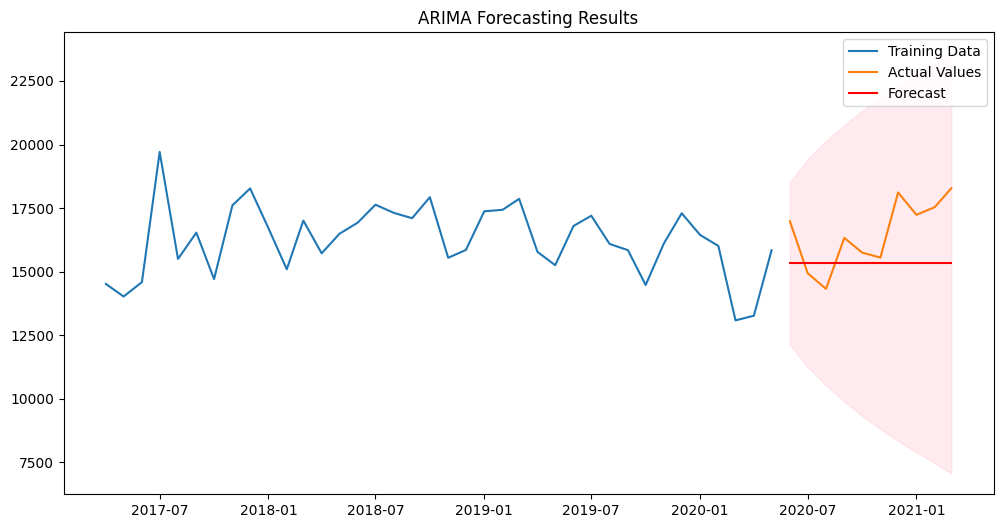

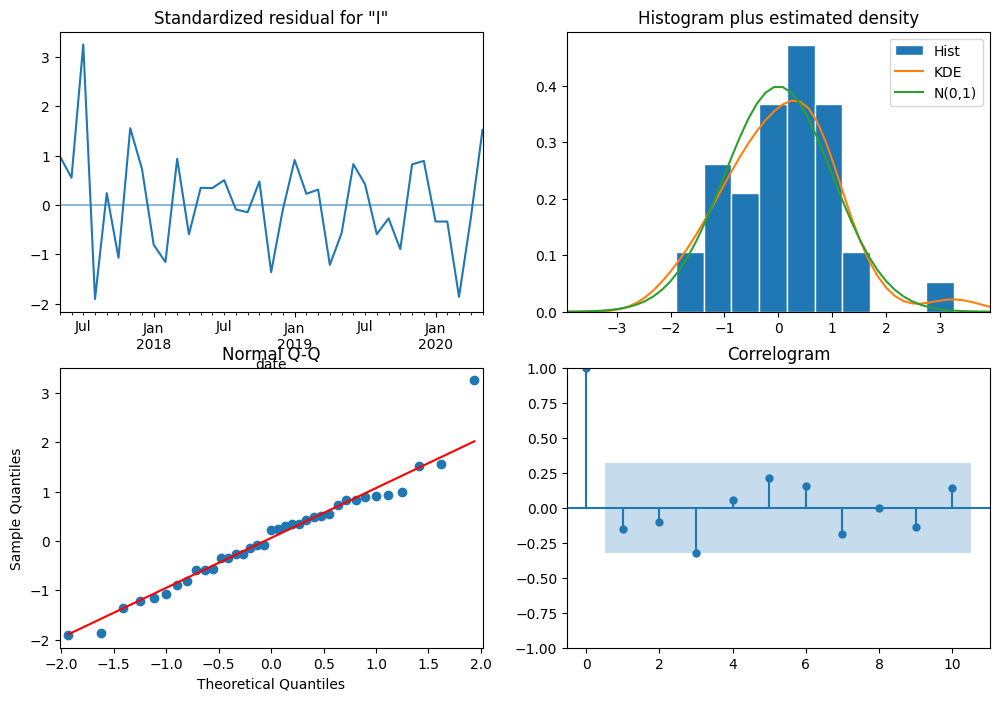

In [106]:
arima_model = TimeSeriesARIMA(
    file_path="../data/HMIS_DATA_CORRECTED_17_21/mh_dist17_21_with_IDs_date_correction.csv",
    value_col="I1",
    selected_district="PUNE",
    split_ratio=0.2
)


# Preprocess data
stationary_series = arima_model.difference_data()

# Split data
arima_model.train, arima_model.test = arima_model.split_data(stationary_series)

# Find optimal parameters
print("Running grid search...")
best_params = arima_model.grid_search(pdq_range=(3, 1, 3))
print(f"Best parameters: {best_params}")

# Train model
model = arima_model.fit()
print(model.summary())

# Generate forecast
forecast_steps = len(arima_model.test)
forecast = arima_model.forecast(forecast_steps)

# Evaluate and visualize
rmse = arima_model.evaluate(arima_model.test, forecast['mean'])
print(f"Test RMSE: {rmse:.2f}")
arima_model.plot_results(arima_model.train, arima_model.test, forecast)

# Generate diagnostic plots
arima_model.diagnostic_plots()
plt.show()
